# Завдання

Фінальний проект по курсу ML.  
                          
Складається з двух складових -  прогнозування  вартості електромобіля та розпізнавання бренду автомобіля по картинці.  
                                    
Для початку - спарсимо данні з сайту Auto-ria.  

Спарсимо 50 сторінок в два файли -   
 1. датасет cars у форматі csv зі стовпцями :
Ціна, Бренд, Модель, Рік випуску авто, Тип палива, відстань, місто, ссилка, опис

 2. картинки усіх цих автомобілів.



                                    

# 1) parsing of data

In [12]:
import requests
from bs4 import BeautifulSoup
import csv
import os
from time import sleep

base_url = 'https://auto.ria.com/uk/search/?indexName=auto,order_auto,newauto_search&categories.main.id=1&country.import.usa.not=-1&price.currency=1&fuel.id[8]=6&abroad.not=0&custom.not=1&page=0&size=100'

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

time_to_sleep_when_captcha = 5

if not os.path.exists('car_images'):
    os.makedirs('car_images')

def parse_page(page_number):
    url = base_url.format(page_number)
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        cars = soup.find_all('section', class_='ticket-item')
        return cars
    else:
        print(f'Ошибка при получении страницы {page_number}: {response.status_code}')
        return []

with open('car_data.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    
    writer.writerow(['Price', 'Brand', 'Model', 'Year', 'FuelType', 'Distance', 'City', 'URL', 'Description'])

    try :
        for page in range(50):  
            cars = parse_page(page)
           
            for index, car in enumerate(cars):
                try:
                    price = car.find('span', class_='green').text.strip()
                except AttributeError:
                    price = 'N/A'

                try:
                    brand_model = car.find('span', class_='blue bold').text.strip().split(' ', 1)
                    brand = brand_model[0]
                    model = brand_model[1] if len(brand_model) > 1 else 'N/A'
                except AttributeError:
                    brand = 'N/A'
                    model = 'N/A'

                try:
                    year = car.find('a', class_='address').text.strip().split(' ')[-1]
                except AttributeError:
                    year = 'N/A'

                try:
                    fuel_type = car.find('li', class_='item-char view-location js-location').find_next_sibling('li').text.strip()
                except AttributeError:
                    fuel_type = 'N/A'

                try:
                    distance = car.find('li', class_='item-char js-race').text.strip()
                except AttributeError:
                    distance = 'N/A'

                try:
                    city = car.find('li', class_='item-char view-location js-location').text.strip()
                except AttributeError:
                    city = 'N/A'

                try:
                    url = car.find('a', class_='address')['href']
                except (AttributeError, KeyError):
                    url = 'N/A'

                try:
                    description = car.find('div', class_='definition-data').text.strip()
                except AttributeError:
                    description = 'N/A'

                try:
                    img_url = car.find('img', class_='outline')['src']
                    img_data = requests.get(img_url).content
                    img_name = f'car_images/{brand}_{model}_page{page}_index{index}.jpg'
                    with open(img_name, 'wb') as img_file:
                        img_file.write(img_data)
                except (AttributeError, KeyError):
                    img_name = 'N/A'

                writer.writerow([price, brand, model, year, fuel_type, distance, city, url, description])

    except:
        sleep(time_to_sleep_when_captcha)
        time_to_sleep_when_captcha += 1

print('file is ready')

file is ready
Parsed 100 cars. Data saved to car_data.csv


Спарсили  50 сторінок сайта, на кожній сторінці по 100 авто.  
                                                       
В нас вийшла папка зі збереженими  зображеннями автомобілів та csv файл з данними про автомобілі.  
                                                                                      
Приступимо до наступного етапу - вивчення отриманої інформаії та її очищення.  
                                                                    

# 2) data info

Зробимо з csv файла - датасет про ціни машин та їх характеристики  




In [1]:
import numpy as np
import pandas as pd

car_df = pd.read_csv('car_data.csv')
car_df.head(20)

,Price,Brand,Model,Year,FuelType,Distance,City,URL,Description
0,25 115,MG,4 EV 64 kWh (204 к.с.),2023,Електро,без пробігу,Одеса ( від ),https://auto.ria.com/uk/newauto/auto-mg-4-1958...,без пробігу Одеса ( від ) Електро Ред...
1,25 136,MG,4 EV 64 kWh (204 к.с.),2023,Електро,без пробігу,Полтава ( від ),https://auto.ria.com/uk/newauto/auto-mg-4-1921...,без пробігу Полтава ( від ) Електро Р...
2,25 136,MG,4 EV 64 kWh (204 к.с.),2023,Електро,без пробігу,Миколаїв ( від ),https://auto.ria.com/uk/newauto/auto-mg-4-1978...,без пробігу Миколаїв ( від ) Електро ...
3,25 115,MG,4 EV 64 kWh (204 к.с.),2023,Електро,без пробігу,Дніпро (Дніпропетровськ) ( від ),https://auto.ria.com/uk/newauto/auto-mg-4-1969...,без пробігу Дніпро (Дніпропетровськ) ( від ...
4,25 115,MG,4 EV 64 kWh (204 к.с.),2023,Електро,без пробігу,Хмельницький ( від ),https://auto.ria.com/uk/newauto/auto-mg-4-1978...,без пробігу Хмельницький ( від ) Електр...
5,25 136,MG,4 EV 64 kWh (204 к.с.),2023,Електро,без пробігу,Київ ( від ),https://auto.ria.com/uk/newauto/auto-mg-4-1978...,без пробігу Київ ( від ) Електро Реду...
6,24 991,MG,4 EV 64 kWh (204 к.с.),2023,Електро,без пробігу,Вінниця ( від ),https://auto.ria.com/uk/newauto/auto-mg-4-1980...,без пробігу Вінниця ( від ) Електро Р...
7,29 699,Volkswagen,ID.4 Crozz,2024,Електро,1 тис. км,Київ ( від ),https://auto.ria.com/uk/auto_volkswagen_id_4_c...,1 тис. км Київ ( від ) Електро Авто...
8,25 115,MG,4 EV 64 kWh (204 к.с.),2023,Електро,без пробігу,Івано-Франківськ ( від ),https://auto.ria.com/uk/newauto/auto-mg-4-1980...,без пробігу Івано-Франківськ ( від ) Ел...
9,25 160,MG,4 EV 64 kWh (204 к.с.),2023,Електро,без пробігу,Харків ( від ),https://auto.ria.com/uk/newauto/auto-mg-4-1910...,без пробігу Харків ( від ) Електро Ре...


In [2]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Price        5000 non-null   object
 1   Brand        5000 non-null   object
 2   Model        5000 non-null   object
 3   Year         5000 non-null   int64 
 4   FuelType     5000 non-null   object
 5   Distance     5000 non-null   object
 6   City         5000 non-null   object
 7   URL          5000 non-null   object
 8   Description  5000 non-null   object
dtypes: int64(1), object(8)
memory usage: 351.7+ KB


In [3]:
car_df.shape

(5000, 9)

In [4]:
np.sum(pd.isna(car_df), axis = 0)

Price          0
Brand          0
Model          0
Year           0
FuelType       0
Distance       0
City           0
URL            0
Description    0
dtype: int64

In [5]:

car_df['City'] = car_df['City'].str.replace(r'\s*\(.*?\)\s*', '', regex=True)
car_df['City']

0              Одеса
1            Полтава
2           Миколаїв
3             Дніпро
4       Хмельницький
            ...     
4995            Київ
4996         Вінниця
4997            Київ
4998            Київ
4999            Київ
Name: City, Length: 5000, dtype: object

In [6]:
car_df['City'].value_counts()

City
Київ                2801
Львів                450
Вінниця              300
Одеса                150
Хмельницький         150
Полтава              150
Рівне                100
Луцьк                100
Трускавець           100
Харків               100
Івано-Франківськ     100
Чернівці              99
Самбір                50
Дніпро                50
Миколаїв              50
Чернігів              50
Дрогобич              50
Старокостянтинів      50
Ужгород               50
Кременчук             50
Name: count, dtype: int64

In [7]:
car_df['Brand'].value_counts()

Brand
BYD              1200
Audi              799
MG                700
Nissan            584
Volkswagen        550
Honda             350
Tesla             267
Zeekr             150
Mercedes-Benz     100
Kia               100
BMW               100
MINI               50
Mitsubishi         50
Name: count, dtype: int64

In [8]:
car_df['Year'].value_counts()

Year
2024    1884
2023    1450
2020     399
2021     350
2022     300
2019     200
2015     117
2018     100
2013      50
2017      50
2016      50
2014      50
Name: count, dtype: int64

In [9]:
car_df.nunique().sort_values()

FuelType         1
Year            12
Brand           13
City            20
Model           29
Distance        35
Price           70
URL            101
Description    101
dtype: int64

Датасет має 9 полів (стовпців) та 5000 записів.  

Наша інформація має 9 ознак. Поля мають різний тип данних.  

Рядків з пустими значеннями не має.  

Є стовпець -опис, попробуємо витягнути потрібну інформацію з нього.  

Завдання прогнозування полягає в тому, щоб визначити ціну втомобіля.  
На ціну може впливати - бренд і модель, тип палива, вік машини, відстань.   

Малоймовірно , що впливає ссилка на сайт, місто в якому проживає продавець.  

# 3) clean data

Преобразуємо стовбець Price , з типу object до int.

In [10]:
def convert_to_int(value):
    return int(str(value).replace(' ', ''))
   
car_df['Price'] = car_df['Price'].apply(convert_to_int)

car_df['Price']

0       25115
1       25136
2       25136
3       25115
4       25115
        ...  
4995    36899
4996    44000
4997    36899
4998    18799
4999    31499
Name: Price, Length: 5000, dtype: int64

Преобразуємо стовбець Distance, з типу object до int. 

In [11]:

def convert_distance(distance):
    if distance == 'без пробігу':
        return 0
    else:
        return int(distance.split()[0].replace('тис.', '000'))

car_df['Distance'] = car_df['Distance'].apply(convert_distance)
car_df['Distance']

0       0
1       0
2       0
3       0
4       0
       ..
4995    1
4996    2
4997    1
4998    1
4999    1
Name: Distance, Length: 5000, dtype: int64

Змінемо стовбець Year на age, та порахуємо скільки років автомобілю

In [12]:
car_df['age'] = 2024 - car_df['Year']
car_df['age']

0       1
1       1
2       1
3       1
4       1
       ..
4995    0
4996    1
4997    0
4998    1
4999    0
Name: age, Length: 5000, dtype: int64


Витащимо зі стовпця Description  
необхідну інформацію про тип двигуна  та наявність авто.  
                                                   
Двигун, якщо не вказано - 0, автомат - 1, редуктор - 2. 

Наявність - 0- не має, 1 - в наявності

In [13]:

car_df['engine'] = car_df['Description'].apply(lambda x: 1 if 'автомат' in x.lower() else (2 if 'редуктор' in x.lower() else 0))

car_df['presence'] = car_df['Description'].apply(lambda x: 1 if 'в наявності' in x.lower() else 0)

car_df[['Description', 'engine', 'presence']].head()

,Description,engine,presence
0,без пробігу Одеса ( від ) Електро Ред...,2,1
1,без пробігу Полтава ( від ) Електро Р...,2,0
2,без пробігу Миколаїв ( від ) Електро ...,2,0
3,без пробігу Дніпро (Дніпропетровськ) ( від ...,2,0
4,без пробігу Хмельницький ( від ) Електр...,2,0


In [14]:
car_df['engine'].value_counts()

engine
1    3583
2     800
0     617
Name: count, dtype: int64

Перевіремо, чи є пусті значення

In [15]:
np.sum(pd.isna(car_df), axis = 0)

Price          0
Brand          0
Model          0
Year           0
FuelType       0
Distance       0
City           0
URL            0
Description    0
age            0
engine         0
presence       0
dtype: int64

Виведемо перші 10 рядків для перевірки датасету.

In [16]:
car_df.head(10)

,Price,Brand,Model,Year,FuelType,Distance,City,URL,Description,age,engine,presence
0,25115,MG,4 EV 64 kWh (204 к.с.),2023,Електро,0,Одеса,https://auto.ria.com/uk/newauto/auto-mg-4-1958...,без пробігу Одеса ( від ) Електро Ред...,1,2,1
1,25136,MG,4 EV 64 kWh (204 к.с.),2023,Електро,0,Полтава,https://auto.ria.com/uk/newauto/auto-mg-4-1921...,без пробігу Полтава ( від ) Електро Р...,1,2,0
2,25136,MG,4 EV 64 kWh (204 к.с.),2023,Електро,0,Миколаїв,https://auto.ria.com/uk/newauto/auto-mg-4-1978...,без пробігу Миколаїв ( від ) Електро ...,1,2,0
3,25115,MG,4 EV 64 kWh (204 к.с.),2023,Електро,0,Дніпро,https://auto.ria.com/uk/newauto/auto-mg-4-1969...,без пробігу Дніпро (Дніпропетровськ) ( від ...,1,2,0
4,25115,MG,4 EV 64 kWh (204 к.с.),2023,Електро,0,Хмельницький,https://auto.ria.com/uk/newauto/auto-mg-4-1978...,без пробігу Хмельницький ( від ) Електр...,1,2,0
5,25136,MG,4 EV 64 kWh (204 к.с.),2023,Електро,0,Київ,https://auto.ria.com/uk/newauto/auto-mg-4-1978...,без пробігу Київ ( від ) Електро Реду...,1,2,0
6,24991,MG,4 EV 64 kWh (204 к.с.),2023,Електро,0,Вінниця,https://auto.ria.com/uk/newauto/auto-mg-4-1980...,без пробігу Вінниця ( від ) Електро Р...,1,2,0
7,29699,Volkswagen,ID.4 Crozz,2024,Електро,1,Київ,https://auto.ria.com/uk/auto_volkswagen_id_4_c...,1 тис. км Київ ( від ) Електро Авто...,0,1,1
8,25115,MG,4 EV 64 kWh (204 к.с.),2023,Електро,0,Івано-Франківськ,https://auto.ria.com/uk/newauto/auto-mg-4-1980...,без пробігу Івано-Франківськ ( від ) Ел...,1,2,0
9,25160,MG,4 EV 64 kWh (204 к.с.),2023,Електро,0,Харків,https://auto.ria.com/uk/newauto/auto-mg-4-1910...,без пробігу Харків ( від ) Електро Ре...,1,2,0


Видаляємо стовпці, які  не впливають на результат визначення ціни

In [17]:
car_dff= car_df.drop(['Year', 'URL', 'FuelType' , 'Description'], axis=1)
car_dff

,Price,Brand,Model,Distance,City,age,engine,presence
0,25115,MG,4 EV 64 kWh (204 к.с.),0,Одеса,1,2,1
1,25136,MG,4 EV 64 kWh (204 к.с.),0,Полтава,1,2,0
2,25136,MG,4 EV 64 kWh (204 к.с.),0,Миколаїв,1,2,0
3,25115,MG,4 EV 64 kWh (204 к.с.),0,Дніпро,1,2,0
4,25115,MG,4 EV 64 kWh (204 к.с.),0,Хмельницький,1,2,0
...,...,...,...,...,...,...,...,...
4995,36899,Audi,Q4 e-tron,1,Київ,0,1,1
4996,44000,Tesla,Model Y,2,Вінниця,1,0,0
4997,36899,Audi,Q4 e-tron,1,Київ,0,1,1
4998,18799,Honda,M-NV,1,Київ,1,1,1


In [18]:

car_dff.describe()

,Price,Distance,age,engine,presence
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,29885.733400,23.217400,1.829800,1.036600,0.446800
std,12774.798082,42.519512,2.458707,0.531147,0.497211
min,5100.000000,0.000000,0.000000,0.000000,0.000000
25%,18999.000000,1.000000,0.000000,1.000000,0.000000
50%,28990.000000,1.000000,1.000000,1.000000,0.000000
75%,36899.000000,34.000000,3.000000,1.000000,1.000000
max,68700.000000,216.000000,11.000000,2.000000,1.000000


Кількісні ознаки датасету:

Price - ціна автомобіля (в доларах США, мінімальна  - 5 100$, максимальна 68 700$)  

Distance - відстань ,яку проїхав автомобіль (мінімальна - 0( нове авто), максимальна 216 тис км)  

age - вік автомобіля (мінімальний -0 (нове авто), максимальний - 11 років)  

engine - двигун (не вказано -0, автомат - 1, редуктор - 2)  

presence - наявність авто (є - 1 чи  ні - 0)  

Категоріальні ознаки датасету:
        
Brand - бренд авто, в датасеті 13 унікальних назв брендів  

Model - модель   авто (29 моделів)  
        
City - місто, в якому власник продає авто, в датасеті 20 міст  

запишемо цей очищенний  датасет в csv файл, який будемо використовувати для презентації даних в Power Bi.

In [19]:

car_dff.to_csv('car_file.csv', index=False, encoding='utf-8-sig')

print("Датасет успешно сохранен в файл 'car_file.csv'")

Датасет успешно сохранен в файл 'car_file.csv'


# 4) vizualization

Зробимо візуалізації, щоб побачити , як впливають різні ознаки на ціну



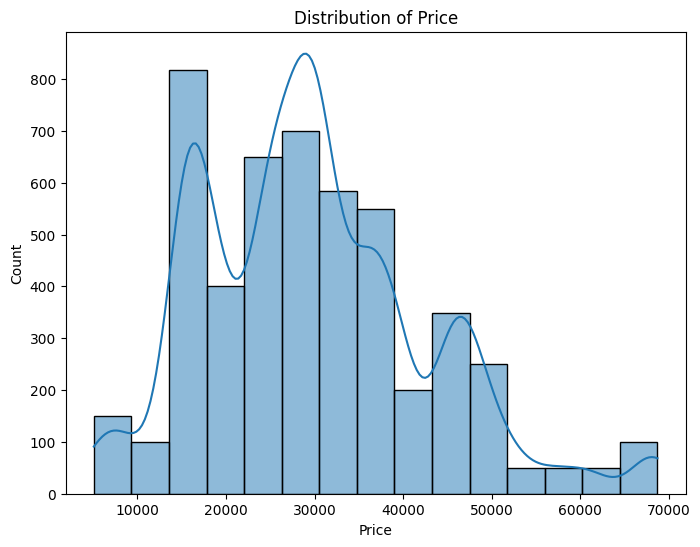

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(data=car_df['Price'], bins=15, kde=True)
plt.title('Distribution of Price')
plt.show()

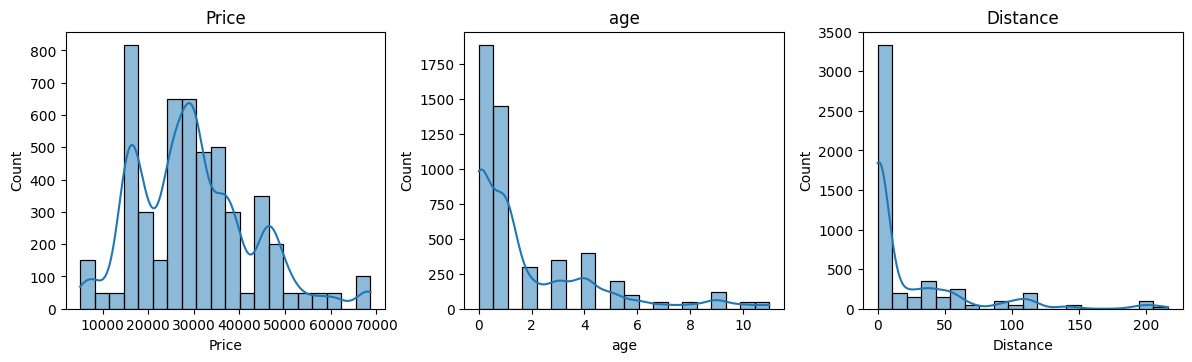

In [21]:
# Distribution of Numerical Features
numerical_features = ['Price', 'age', 'Distance']

plt.figure(figsize=(20, 10))
for feature in numerical_features:
    plt.subplot(3, 5, numerical_features.index(feature) + 1)
    sns.histplot(data=car_df[feature], bins=20, kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

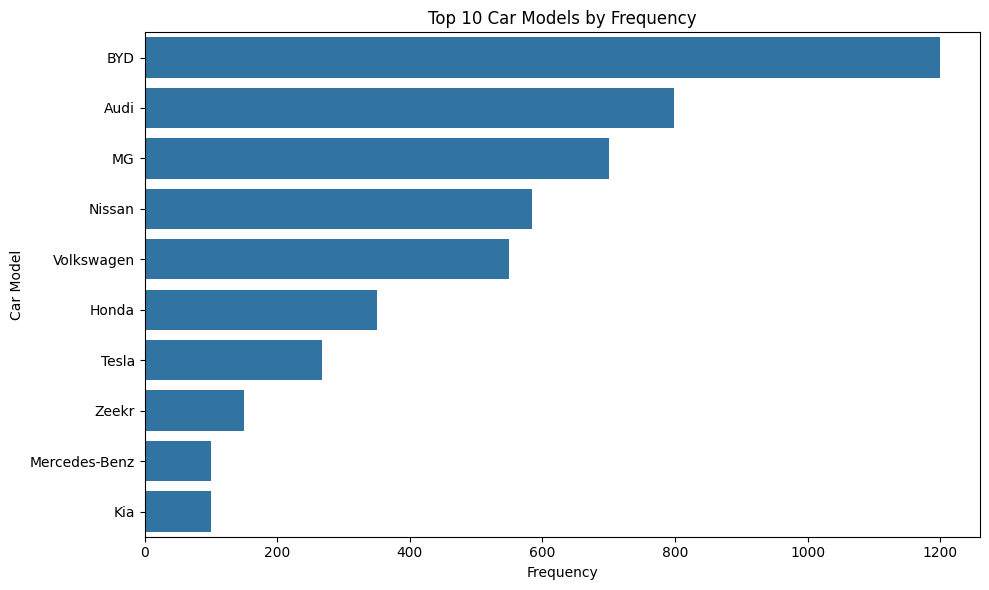

In [22]:
n = 10  # Number of top car models to 

top_car_models = car_df['Brand'].value_counts().head(n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_car_models.values, y=top_car_models.index)
plt.title(f'Top {n} Car Models by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Car Model')
plt.tight_layout()
plt.show()

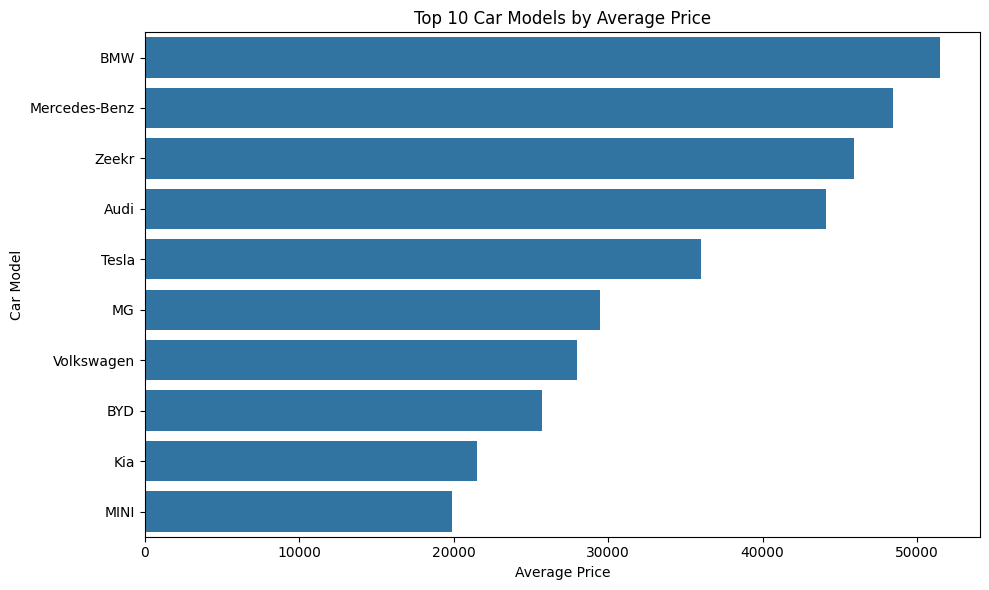

In [23]:
# Calculate average price for each car model
avg_prices_by_car = car_df.groupby('Brand')['Price'].mean().sort_values(ascending=False)

n = 10  
top_car_models = avg_prices_by_car.head(n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_car_models.values, y=top_car_models.index)
plt.title(f'Top {n} Car Models by Average Price')
plt.xlabel('Average Price')
plt.ylabel('Car Model')
plt.tight_layout()
plt.show()

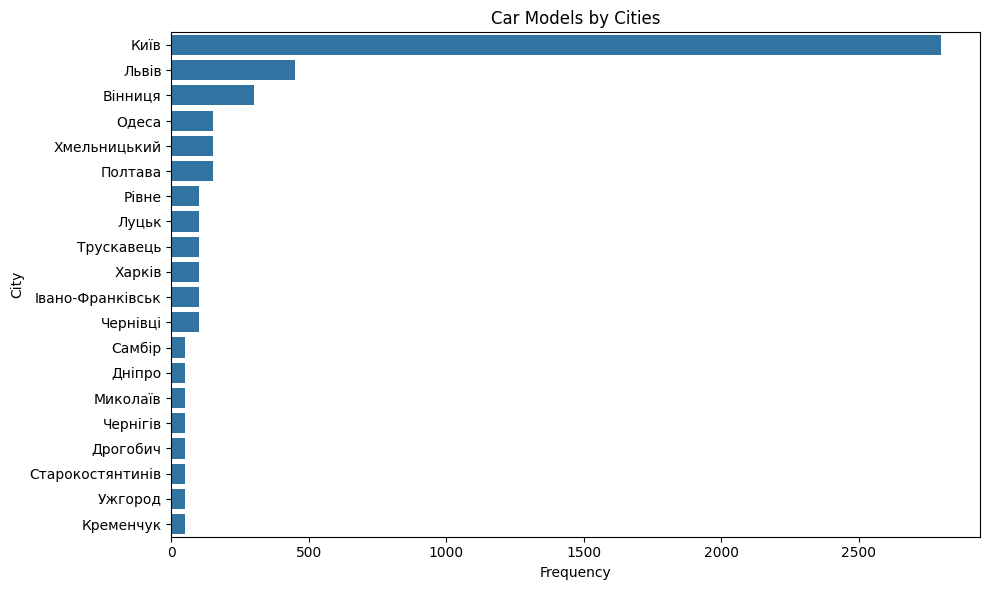

In [24]:

city_car_models = car_df['City'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=city_car_models.values, y=city_car_models.index)
plt.title(f'Car Models by Cities')
plt.xlabel('Frequency')
plt.ylabel('City')
plt.tight_layout()
plt.show()

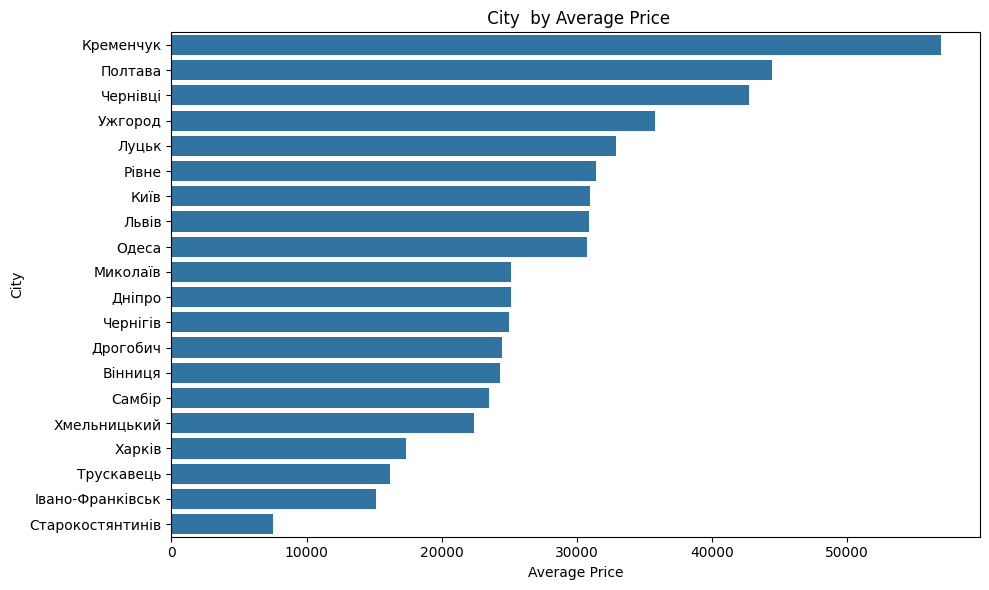

In [25]:
# Calculate average price for each city
avg_prices_by_city = car_df.groupby('City')['Price'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_prices_by_city.values, y=avg_prices_by_city.index)
plt.title(f' City  by Average Price')
plt.xlabel('Average Price')
plt.ylabel('City')
plt.tight_layout()
plt.show()

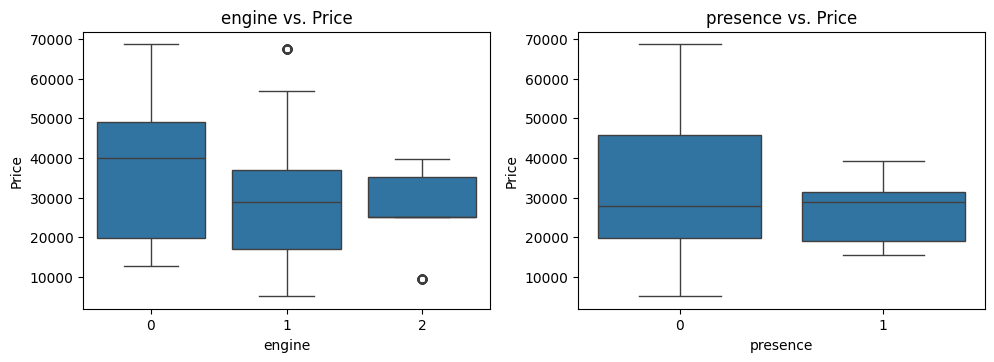

In [26]:

categorical_columns =  ['engine', 'presence']

plt.figure(figsize=(15, 10))
for feature in categorical_columns:
    plt.subplot(3, 3, categorical_columns.index(feature) + 1)
    sns.boxplot(data=car_df, x=feature, y='Price')
    plt.title(f'{feature} vs. Price')
plt.tight_layout()
plt.show()

C:\Users\Natalia\AppData\Local\Temp\ipykernel_7188\3149454782.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


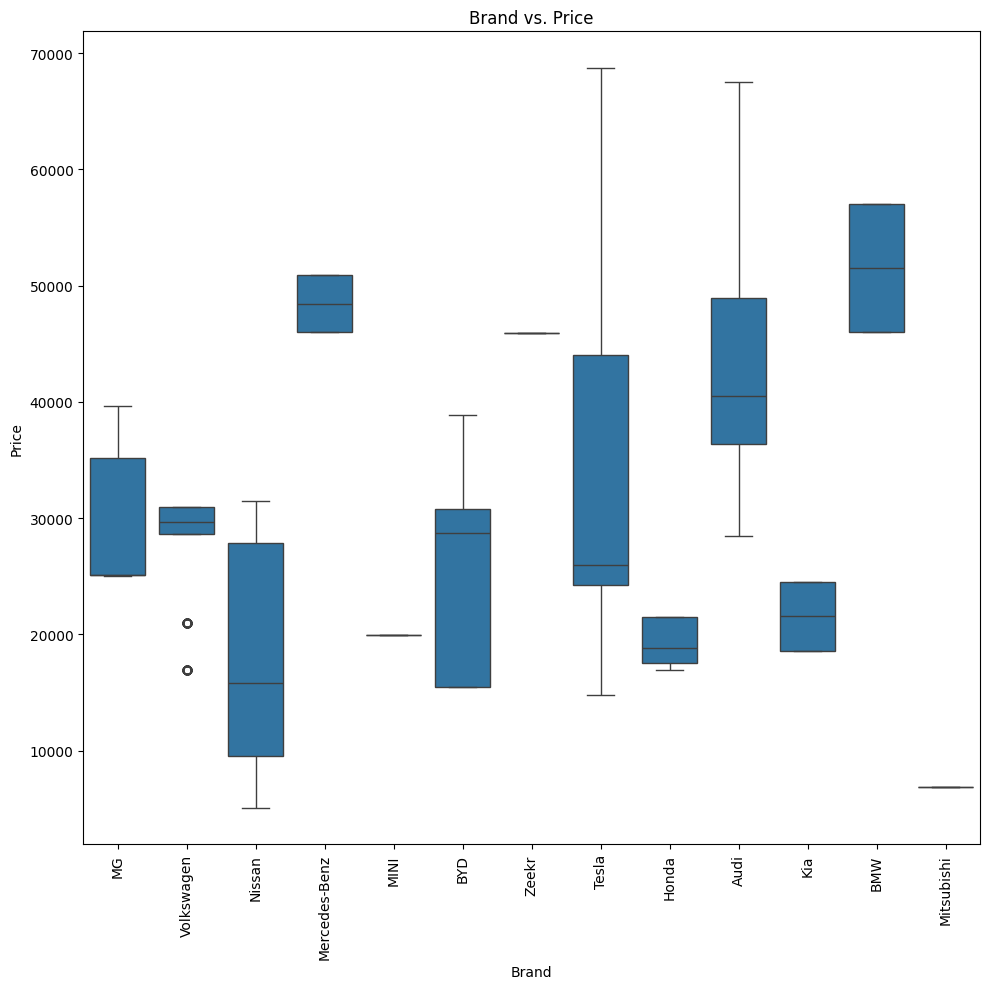

In [27]:

plt.figure(figsize=(10, 10))

ax = sns.boxplot(data=car_df, x=car_df['Brand'], y='Price')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.title('Brand vs. Price')
plt.tight_layout()
plt.show()




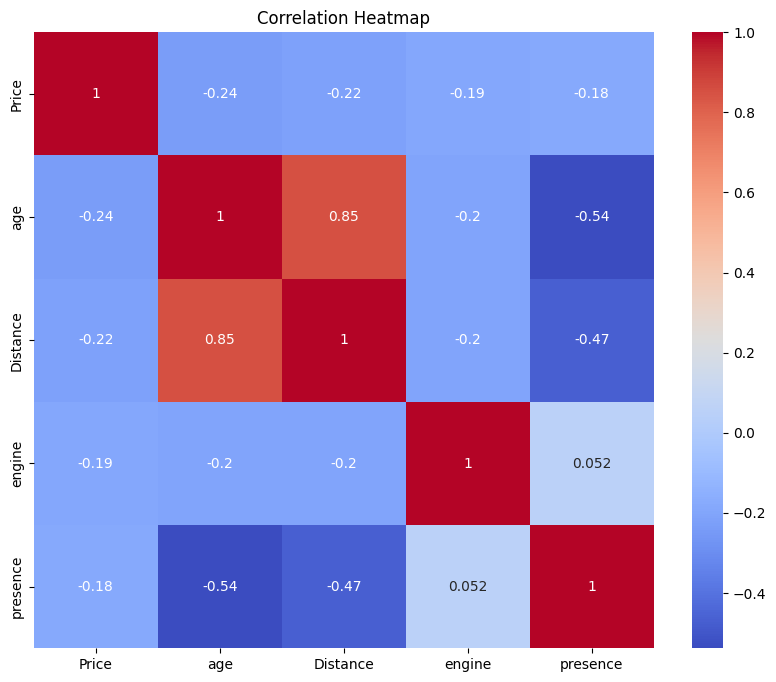

In [28]:
# Correlation Analysis
numerical_features = ['Price', 'age', 'Distance', 'engine', 'presence']

correlation_matrix = car_df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

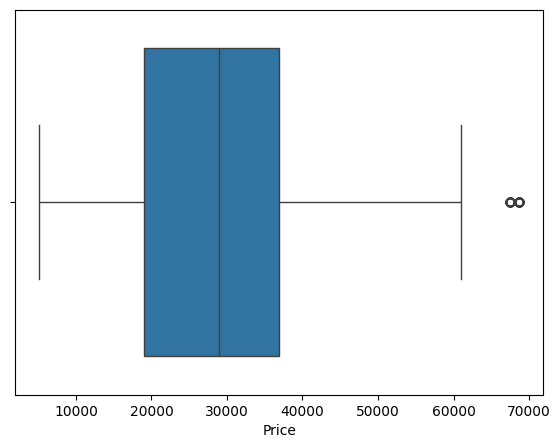

In [29]:

fig = plt.figure(figsize=[15,5])
 
plt.subplot(1,2,1)
sns.boxplot(x=car_dff['Price'], data=car_dff)
plt.show()

медіана ціни біля 29 000  

нижній квартиль - 18 000, верхній квартиль - 37 000

максимальне значення 60 000

є викид на 68 тис


# 5) data pre-processing

переводимо категоріальні ознаки в числові



In [30]:
from sklearn.preprocessing import LabelEncoder

l_encoder=LabelEncoder()
car_dff['City']=l_encoder.fit_transform(car_dff['City'])

car_dff['Brand']=l_encoder.fit_transform(car_dff['Brand'])

car_dff['Model']=l_encoder.fit_transform(car_dff['Model'])

car_dff.head(10)

,Price,Brand,Model,Distance,City,age,engine,presence
0,25115,5,1,0,9,1,2,1
1,25136,5,1,0,10,1,2,0
2,25136,5,1,0,8,1,2,0
3,25115,5,1,0,2,1,2,0
4,25115,5,1,0,17,1,2,0
5,25136,5,1,0,4,1,2,0
6,24991,5,1,0,1,1,2,0
7,29699,11,7,1,4,0,1,1
8,25115,5,1,0,0,1,2,0
9,25160,5,1,0,16,1,2,0


Розділяємо вибірку на Х (незалежні ознаки) та y (цільову змінну).


In [31]:
X = car_dff.drop(columns=["Price"])
y = car_dff["Price"]

Розділяємо вибірку на тренувальну та тестувальну


In [32]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6) models

In [67]:
#Створіюмо пустий словник, куди в подальшому будемо записувати результати моделей.

results_models={}

Перша модель -LinearRegression, підбирати параметри будемо завдяки GridSearchCV

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('poly', PolynomialFeatures()),
    ('linear', LinearRegression())
])

param_grid = {
    'poly__degree': [1, 2, 3], 
    'linear__fit_intercept': [True, False],  
    'linear__positive': [True, False]  
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

best_logmodel = grid_search.best_estimator_

y_test_pred = best_logmodel.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE:", rmse)

results = { "Linear Regression" : {'Score train':best_logmodel.score(X_train, y_train), 'Score test': best_logmodel.score(X_test, y_test), 'RMSE': rmse}}

results

Best params: {'linear__fit_intercept': False, 'linear__positive': False, 'poly__degree': 3}
Best score: -0.998293964197965
RMSE: 533.0829701392554


{'Linear Regression': {'Score train': 0.998329303852391,
  'Score test': 0.9983080586887391,
  'RMSE': 533.0829701392554}}

LinearRegression з найкращими параметрами - linear__fit_intercept': False, 'linear__positive': False, 'poly__degree': 3  

показала результат *Score test 0.9983*  
                               
спробуємо інші моделі  

In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dt_regressor = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(dt_regressor, param_grid, cv=5,  n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

best_dt_model = grid_search.best_estimator_

y_test_pred = best_dt_model.predict(X_test)

tree_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("RMSE:", tree_rmse)

results ["Decision tree"] = {}
results ["Decision tree"] ['Score train']= best_dt_model.score(X_train, y_train)
results ["Decision tree"]['Score test']= best_dt_model.score(X_test, y_test)
results ["Decision tree"] ['RMSE']= tree_rmse

print(results)

Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: -0.9982991439472523
RMSE: 531.973804303285
{'Linear Regression': {'Score train': 0.998329303852391, 'Score test': 0.9983080586887391, 'RMSE': 533.0829701392554}, 'Decision tree': {'Score train': 0.9983337458795627, 'Score test': 0.9983150920823115, 'RMSE': 531.973804303285}}


модель DecisionTreeRegressor -   
найкращі параметри: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}  
*Score test - 0.99829*

In [37]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_regressor = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(rf_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

best_rf_model = grid_search.best_estimator_

y_test_pred = best_rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("RMSE:", rf_rmse)

results ["Random Forest"] = {}
results ["Random Forest"] ['Score train']= best_rf_model.score(X_train, y_train)
results ["Random Forest"]['Score test']= best_rf_model.score(X_test, y_test)
results ["Random Forest"] ['RMSE']= rf_rmse

results

Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score: 273285.4285540905
RMSE: 531.9922877393982


{'Linear Regression': {'Score train': 0.998329303852391,
  'Score test': 0.9983080586887391,
  'RMSE': 533.0829701392554},
 'Decision tree': {'Score train': 0.9983337458795627,
  'Score test': 0.9983150920823115,
  'RMSE': 531.973804303285},
 'Random Forest': {'Score train': 0.9983336485824842,
  'Score test': 0.9983149749959864,
  'RMSE': 531.9922877393982}}

RandomForestRegressor  
найкращі параметри: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}  

*Score test   0.9983*



In [38]:
import xgboost as xgb

param_grid = {
    'max_depth':  [None, 10, 20, 30],
    'learning_rate':[ 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 150],
}

xgb_regressor = xgb.XGBRegressor()

grid_search = GridSearchCV(xgb_regressor, param_grid, cv=5,  n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

best_xgb_model = grid_search.best_estimator_

y_test_pred = best_xgb_model.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("RMSE:", xgb_rmse)


results ["XGBoost"] = {}
results ["XGBoost"] ['Score train']= best_xgb_model.score(X_train, y_train)
results ["XGBoost"]['Score test']= best_xgb_model.score(X_test, y_test)
results ["XGBoost"] ['RMSE']= xgb_rmse
results

Best params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 50}
Best score: -0.9982991475899741
RMSE: 531.9646320073973


{'Linear Regression': {'Score train': 0.998329303852391,
  'Score test': 0.9983080586887391,
  'RMSE': 533.0829701392554},
 'Decision tree': {'Score train': 0.9983337458795627,
  'Score test': 0.9983150920823115,
  'RMSE': 531.973804303285},
 'Random Forest': {'Score train': 0.9983336485824842,
  'Score test': 0.9983149749959864,
  'RMSE': 531.9922877393982},
 'XGBoost': {'Score train': 0.9983337437469386,
  'Score test': 0.9983151501841977,
  'RMSE': 531.9646320073973}}

XGBRegressor  
найкращі параметри {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 150}  

*score test - 0.9983*

In [39]:

from sklearn.model_selection import  RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from scipy.stats import uniform, randint

base_models = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('gb', GradientBoostingRegressor(random_state=42))
]

final_model = LinearRegression()

stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=final_model,
    cv=5
)

param_distributions = {
    'rf__n_estimators': randint(10, 200),
    'rf__max_depth': randint(2, 20),
    'gb__n_estimators': randint(10, 200),
    'gb__learning_rate': uniform(0.01, 0.5),
    'final_estimator__fit_intercept': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=stacking_regressor,
    param_distributions=param_distributions,
    n_iter=100,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best score:", -random_search.best_score_)

stack_best_model = random_search.best_estimator_

y_test_pred = stack_best_model.predict(X_test)
stack_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("RMSE:", rf_rmse)

results ["Stacking"] = {}
results ["Stacking"] ['Score train']= stack_best_model.score(X_train, y_train)
results ["Stacking"]['Score test']= stack_best_model.score(X_test, y_test)
results ["Stacking"] ['RMSE']= stack_rmse
results

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params: {'final_estimator__fit_intercept': False, 'gb__learning_rate': 0.32670187825521174, 'gb__n_estimators': 143, 'rf__max_depth': 13, 'rf__n_estimators': 53}
Best score: 273278.79975036613
RMSE: 531.9922877393982


{'Linear Regression': {'Score train': 0.998329303852391,
  'Score test': 0.9983080586887391,
  'RMSE': 533.0829701392554},
 'Decision tree': {'Score train': 0.9983337458795627,
  'Score test': 0.9983150920823115,
  'RMSE': 531.973804303285},
 'Random Forest': {'Score train': 0.9983336485824842,
  'Score test': 0.9983149749959864,
  'RMSE': 531.9922877393982},
 'XGBoost': {'Score train': 0.9983337437469386,
  'Score test': 0.9983151501841977,
  'RMSE': 531.9646320073973},
 'Stacking': {'Score train': 0.9983335898206366,
  'Score test': 0.9983137897545759,
  'RMSE': 532.179355719744}}

StackingRegressor  
        найкращі параметри  
        {'final_estimator__fit_intercept': False,  
         'gb__learning_rate': 0.32670187825521174,  
         'gb__n_estimators': 143,  
         'rf__max_depth': 13,  
         'rf__n_estimators': 53}  
 
**score test - 0.9983*

In [40]:
df_result = pd.DataFrame(results)
df_res =df_result.transpose()
df_res.sort_values(by= 'Score test', ascending= False)

,Score train,Score test,RMSE
XGBoost,0.998334,0.998315,531.964632
Decision tree,0.998334,0.998315,531.973804
Random Forest,0.998334,0.998315,531.992288
Stacking,0.998334,0.998314,532.179356
Linear Regression,0.998329,0.998308,533.082970


ми бачимо, що у всіх моделях хороші результати.  
                                   
Але найкращі модель XGBoost Та Decision Tree, зі Score 0,998315.  



# 7) predict

In [68]:
#31499
car = {'Brand' : [37] ,
          'Model' : [12],
          'Distance': [1],
          'City' : [58] ,
          'age' : [0],
          'engine': [1],
          'presence' : [1] 
}
df_car = pd.DataFrame(car)

In [43]:
print('Модель XBoostmodel видає ціну - ', best_xgb_model.predict(df_car))
print('Модель Decision Tree видає ціну - ', best_dt_model.predict(df_car))
print('Модель Random Forest видає ціну - ', best_rf_model.predict(df_car))
print('Модель Stacking видає ціну - ', stack_best_model.predict(df_car))
print('Модель Logmodel видає ціну - ', best_logmodel.predict(df_car))

Модель XBoostmodel видає ціну -  [30337.104]
Модель Decision Tree видає ціну -  [45899.]
Модель Random Forest видає ціну -  [34760.65333044]
Модель Stacking видає ціну -  [30589.12074218]
Модель Logmodel видає ціну -  [3.38236575e+17]


In [44]:
#27299
car2 = {'Brand' : [5] ,
          'Model' : [151],
          'Distance': [1],
          'City' : [58] ,
          'age' : [0],
          'engine': [1],
          'presence' : [1] 
}
df_car2 = pd.DataFrame(car2)

In [46]:
print('Модель XBoostmodel видає ціну - ', best_xgb_model.predict(df_car2))
print('Модель Decision Tree видає ціну - ', best_dt_model.predict(df_car2))
print('Модель Random Forest видає ціну - ', best_rf_model.predict(df_car2))
print('Модель Stacking видає ціну - ', stack_best_model.predict(df_car2))
print('Модель Logmodel видає ціну - ', best_logmodel.predict(df_car2))

Модель XBoostmodel видає ціну -  [18998.598]
Модель Decision Tree видає ціну -  [28399.]
Модель Random Forest видає ціну -  [23833.90506325]
Модель Stacking видає ціну -  [19456.00943768]
Модель Logmodel видає ціну -  [-3.93147256e+17]


# 8) car_images

In [33]:
print(car_df['Brand'].value_counts().head(10))

Brand
BYD              1200
Audi              799
MG                700
Nissan            584
Volkswagen        550
Honda             350
Tesla             267
Zeekr             150
Mercedes-Benz     100
Kia               100
Name: count, dtype: int64


In [34]:
import os
import pandas as pd
from PIL import Image

image_folder = 'C:/Users/Natalia/Desktop/Data Wizasrd/ml final/car_images'

#image_folder = '/data/notebook_files/car_images'

brand_df = ['Tesla', 'Audi', 'Kia', 'Honda',  'BYD', 'Mercedes-Benz', 'MG','Volkswagen','Nissan', 'Zeekr'] 

img_size = (128, 128)

images = []
brands = []
faulty_images = []  

for filename in os.listdir(image_folder):
    if filename.endswith(('.jpg', '.jpeg', '.png', '.gif')):
        img_path = os.path.join(image_folder, filename)
        
        try:  
            img = Image.open(img_path)
        except OSError:
            print(f"Couldn't open {img_path}")
            faulty_images.append(filename)  
            continue 
        
        for brand in brand_df:
            if brand.lower() in filename.lower():
                brands.append(brand)
                images.append(img)
                break
        else:
            brands.append('Unknown')
            images.append(img)

print(f"Found {len(brands)} images")
print(f"Unique brands: {set(brands)}")

print(f"Couldn't open {len(faulty_images)} images")

Found 5000 images
Unique brands: {'Volkswagen', 'BYD', 'Zeekr', 'Kia', 'Honda', 'Audi', 'Tesla', 'MG', 'Mercedes-Benz', 'Unknown', 'Nissan'}
Couldn't open 0 images


In [35]:
print(f"Quantity of unique brands: {len(set(brands))}")

Quantity of unique brands: 11


In [36]:
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

images_resized = [np.array(img.resize(img_size)) for img in images]
images = np.array(images_resized)

brands = np.array(brands)

images = images.astype('float32') / 255.0

unique_brands = list(set(brands))
brand_indices = [unique_brands.index(brand) for brand in brands]
brands = to_categorical(brand_indices, num_classes=len(unique_brands))

X_train, X_test, y_train, y_test = train_test_split(images, brands, test_size=0.3, random_state=42)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(unique_brands), activation='softmax'))  

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

c:\Users\Natalia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 524ms/step - accuracy: 0.2900 - loss: 2.0716 - val_accuracy: 0.9540 - val_loss: 0.3926
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 525ms/step - accuracy: 0.9127 - loss: 0.3248 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 586ms/step - accuracy: 0.9906 - loss: 0.0376 - val_accuracy: 1.0000 - val_loss: 6.7428e-05
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 584ms/step - accuracy: 0.9950 - loss: 0.0166 - val_accuracy: 1.0000 - val_loss: 3.6956e-05
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 579ms/step - accuracy: 0.9961 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 9.6336e-06
Test loss: 9.633586159907281e-06
Test accuracy: 1.0


Обидва значення (дуже низький loss та 100% accuracy)  
вказують на те, що наша модель демонструє ідеальні результати на тестових даних.  
Це може означати, що модель чудово справляється із завданням класифікації бренду автомобіля за зображенням.  
                                                                                               

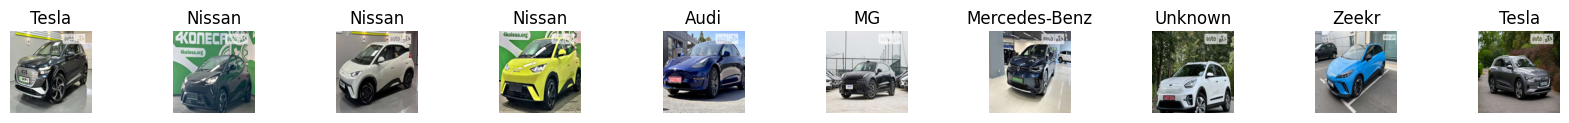

In [37]:
import matplotlib.pyplot as plt

BRANDS = np.array(['Mercedes-Benz', 'Nissan', 'MG', 'Unknown', 'Kia', 'Tesla', 'Audi', 'Zeekr', 'Honda', 'BYD', 'Volkswagen'])

def show_images(images, brands, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    axes = axes.ravel()

    for i in range(num_images):
        index = np.random.randint(0, len(images))
        axes[i].imshow(images[index])
        axes[i].set_title(BRANDS[brands[index]], fontsize=12)
        axes[i].axis('off')

    plt.subplots_adjust(wspace=1)

# Undo the normalization for displaying purposes
x_train_display = (X_train * 255).astype('uint8')
y_train_display = y_train.argmax(axis=-1)

show_images(x_train_display, y_train_display)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


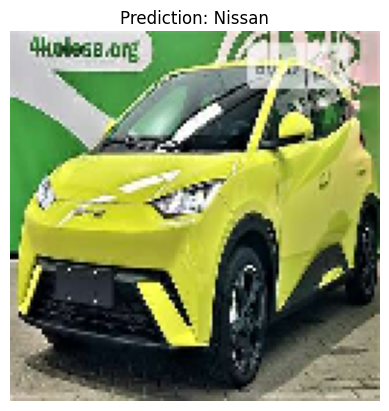

Predicted brand: Nissan


In [39]:
import tensorflow 
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 

img_size = (128, 128)

brands = np.array(['Mercedes-Benz', 'Nissan', 'MG', 'Unknown', 'Kia', 'Tesla', 'Audi', 'Zeekr', 'Honda', 'BYD', 'Volkswagen'])

def predict_image(img_path):
    img = keras.utils.load_img(img_path, target_size=img_size)
    img_array = keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)

    predicted_class = np.argmax(prediction[0])
    
    predicted_brand = brands[predicted_class]
    
    plt.imshow(img)
    plt.title(f'Prediction: {predicted_brand}')
    plt.axis('off') 
    plt.show()
    
    return predicted_brand

image_path = 'C:/Users/Natalia/Desktop/Data Wizasrd/ml final/cars/1-BYD.jpg'

#image_path = 'data/notebook_files/cars/1-BYD.jpg'

predicted_brand = predict_image(image_path)
print(f"Predicted brand: {predicted_brand}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


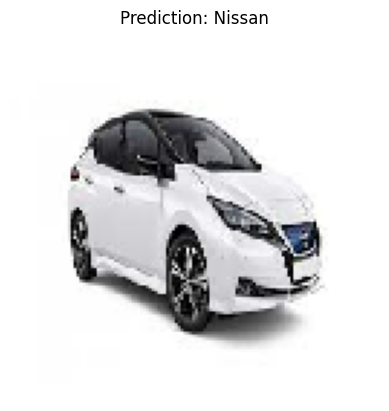

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


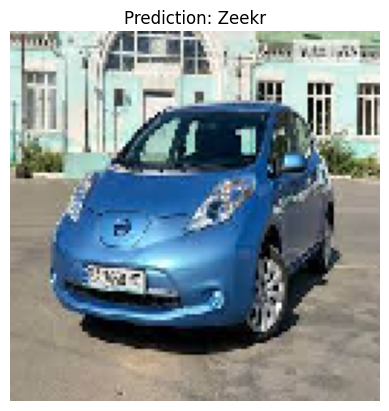

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


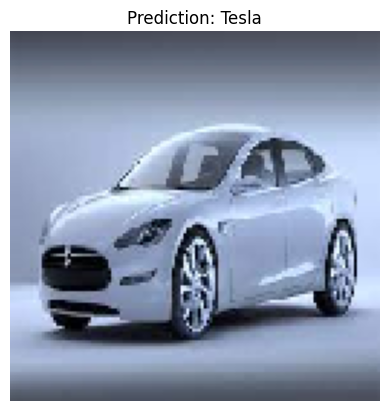

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


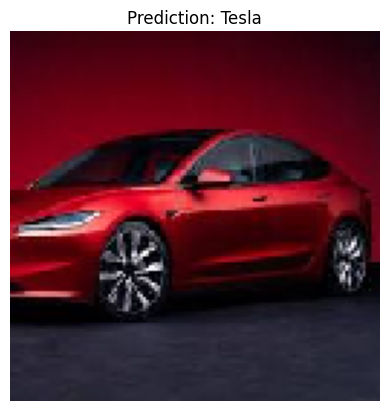

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


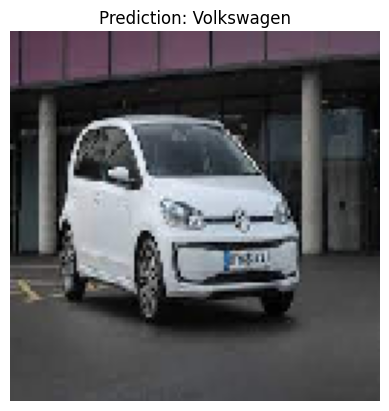

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


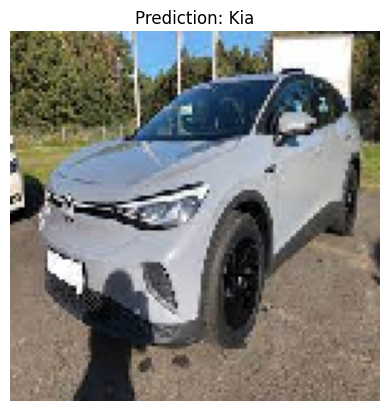

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


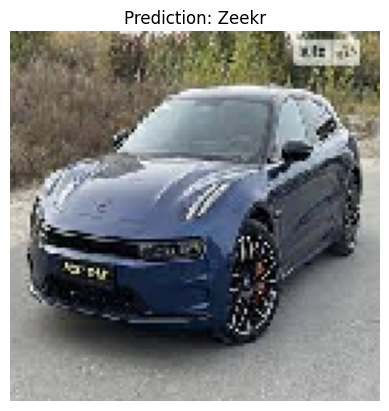

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


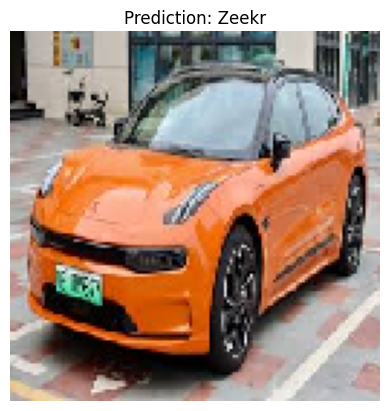

File: nissan.jfif, Predicted brand: Nissan
File: nissan2.jfif, Predicted brand: Zeekr
File: tesla2.jfif, Predicted brand: Tesla
File: tesla3.jfif, Predicted brand: Tesla
File: vw.jfif, Predicted brand: Volkswagen
File: vw2.jfif, Predicted brand: Kia
File: zeekr.jfif, Predicted brand: Zeekr
File: zeekr2.jfif, Predicted brand: Zeekr


In [54]:
import os

image_folder = 'C:/Users/Natalia/Desktop/Data Wizasrd/ml final/cars'

#image_folder = 'data/notebook_files/cars'

results = []

for filename in os.listdir(image_folder):
    if filename.endswith(('.jpg', '.jpeg', '.png', '.gif', 'jfif')):
        img_path = os.path.join(image_folder, filename)
        predicted_brand = predict_image(img_path)
        results.append((filename, predicted_brand))

# Вывод результатов
for filename, brand in results:
    print(f"File: {filename}, Predicted brand: {brand}")

з восьми картинок правильно визначило 6 брендів авто.
